In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [2]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


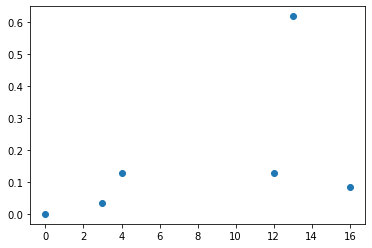

In [14]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [17]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        

    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()


In [18]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()




In [19]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [20]:
print(np.allclose(np.identity(basis.Ns),exp_gate(0,np.pi/3).conj().T@exp_gate(0,np.pi/3),atol = 1e-8,rtol= 1e-8))

True


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [21]:
def R(i,theta):
    
    if i%9 == 0:
        return(exp_gate(0,theta))

    if i%9 == 1:
        return(exp_gate(1,theta))

    if i%9 == 2:
        return(exp_gate(2,theta))

    
    if i%9 == 3:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%9 == 4:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%9 == 5:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%9 == 6:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%9 == 7:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%9 == 8:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
        

def S(i,theta):
    
    if i%9 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%9 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%9 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())
     
    if i%9 == 3:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%9 == 4:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%9 == 5:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%9 == 6:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%9 == 7:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%9 == 8:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())

In [22]:
coeff = 9
stepp = 1000
t_final = 10

In [23]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [24]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])
        
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[coeff*N-1-k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k,theta[k])@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[coeff*N-1-i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    


    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [25]:
time_domain = np.linspace(0, t_final, stepp)


In [26]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [27]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-11 15:58:14.358614
start 2022-08-11 15:58:14.481083
stop_reduce 2022-08-11 15:58:14.840746
2022-08-11 15:58:14.843957
0
2022-08-11 15:58:14.844069
start 2022-08-11 15:58:14.966932
stop_reduce 2022-08-11 15:58:15.324228
2022-08-11 15:58:15.325151
0.005
2022-08-11 15:58:15.325200
start 2022-08-11 15:58:15.450104
stop_reduce 2022-08-11 15:58:15.810288
2022-08-11 15:58:15.811096
0.005
2022-08-11 15:58:15.811146
start 2022-08-11 15:58:15.946452
stop_reduce 2022-08-11 15:58:16.304679
2022-08-11 15:58:16.305465
0.01
2022-08-11 15:58:16.305515
start 2022-08-11 15:58:16.430875
stop_reduce 2022-08-11 15:58:16.796727
2022-08-11 15:58:16.797539
0.01
2022-08-11 15:58:16.797590
start 2022-08-11 15:58:16.920617
stop_reduce 2022-08-11 15:58:17.302439
2022-08-11 15:58:17.303195
0.015
2022-08-11 15:58:17.303248
start 2022-08-11 15:58:17.440827
stop_reduce 2022-08-11 15:58:17.797133
2022-08-11 15:58:17.797925
0.015
2022-08-11 15:58:17.797971
start 2022-08-11 15:58:17.919980
stop_reduce 2022-08-11

stop_reduce 2022-08-11 15:58:44.476038
2022-08-11 15:58:44.476890
0.15
2022-08-11 15:58:44.477067
start 2022-08-11 15:58:44.598873
stop_reduce 2022-08-11 15:58:44.951101
2022-08-11 15:58:44.951730
0.155
2022-08-11 15:58:44.951770
start 2022-08-11 15:58:45.074845
stop_reduce 2022-08-11 15:58:45.427318
2022-08-11 15:58:45.428059
0.155
2022-08-11 15:58:45.428105
start 2022-08-11 15:58:45.551316
stop_reduce 2022-08-11 15:58:45.903023
2022-08-11 15:58:45.903711
0.16
2022-08-11 15:58:45.903762
start 2022-08-11 15:58:46.025493
stop_reduce 2022-08-11 15:58:46.386547
2022-08-11 15:58:46.387465
0.16
2022-08-11 15:58:46.387582
start 2022-08-11 15:58:46.509338
stop_reduce 2022-08-11 15:58:46.863804
2022-08-11 15:58:46.864535
0.165
2022-08-11 15:58:46.864583
start 2022-08-11 15:58:46.986609
stop_reduce 2022-08-11 15:58:47.340133
2022-08-11 15:58:47.340935
0.165
2022-08-11 15:58:47.340980
start 2022-08-11 15:58:47.462585
stop_reduce 2022-08-11 15:58:47.818130
2022-08-11 15:58:47.818935
0.17
2022-08-

stop_reduce 2022-08-11 15:59:12.472736
2022-08-11 15:59:12.473397
0.2950000000000001
2022-08-11 15:59:12.473512
start 2022-08-11 15:59:12.594804
stop_reduce 2022-08-11 15:59:12.945699
2022-08-11 15:59:12.946443
0.3000000000000001
2022-08-11 15:59:12.946578
start 2022-08-11 15:59:13.067792
stop_reduce 2022-08-11 15:59:13.418686
2022-08-11 15:59:13.419379
0.3000000000000001
2022-08-11 15:59:13.419498
start 2022-08-11 15:59:13.540634
stop_reduce 2022-08-11 15:59:13.890304
2022-08-11 15:59:13.890947
0.3050000000000001
2022-08-11 15:59:13.891099
start 2022-08-11 15:59:14.012098
stop_reduce 2022-08-11 15:59:14.361874
2022-08-11 15:59:14.362456
0.3050000000000001
2022-08-11 15:59:14.362502
start 2022-08-11 15:59:14.483460
stop_reduce 2022-08-11 15:59:14.833003
2022-08-11 15:59:14.833656
0.3100000000000001
2022-08-11 15:59:14.833704
start 2022-08-11 15:59:14.954765
stop_reduce 2022-08-11 15:59:15.304223
2022-08-11 15:59:15.304828
0.3100000000000001
2022-08-11 15:59:15.304936
start 2022-08-11 1

stop_reduce 2022-08-11 15:59:40.128873
2022-08-11 15:59:40.129716
0.4400000000000002
2022-08-11 15:59:40.129768
start 2022-08-11 15:59:40.252824
stop_reduce 2022-08-11 15:59:40.605997
2022-08-11 15:59:40.606734
0.4400000000000002
2022-08-11 15:59:40.606801
start 2022-08-11 15:59:40.728321
stop_reduce 2022-08-11 15:59:41.081239
2022-08-11 15:59:41.081943
0.44500000000000023
2022-08-11 15:59:41.082004
start 2022-08-11 15:59:41.203763
stop_reduce 2022-08-11 15:59:41.556871
2022-08-11 15:59:41.557659
0.44500000000000023
2022-08-11 15:59:41.557710
start 2022-08-11 15:59:41.678690
stop_reduce 2022-08-11 15:59:42.030552
2022-08-11 15:59:42.031248
0.45000000000000023
2022-08-11 15:59:42.031308
start 2022-08-11 15:59:42.152390
stop_reduce 2022-08-11 15:59:42.504169
2022-08-11 15:59:42.504860
0.45000000000000023
2022-08-11 15:59:42.504917
start 2022-08-11 15:59:42.626337
stop_reduce 2022-08-11 15:59:42.977820
2022-08-11 15:59:42.978486
0.45500000000000024
2022-08-11 15:59:42.978547
start 2022-08

stop_reduce 2022-08-11 16:00:08.707810
2022-08-11 16:00:08.708601
0.5800000000000003
2022-08-11 16:00:08.708721
start 2022-08-11 16:00:08.853535
stop_reduce 2022-08-11 16:00:09.254936
2022-08-11 16:00:09.255736
0.5850000000000003
2022-08-11 16:00:09.255786
start 2022-08-11 16:00:09.390440
stop_reduce 2022-08-11 16:00:09.780862
2022-08-11 16:00:09.781571
0.5850000000000003
2022-08-11 16:00:09.781720
start 2022-08-11 16:00:09.916900
stop_reduce 2022-08-11 16:00:10.317656
2022-08-11 16:00:10.318335
0.5900000000000003
2022-08-11 16:00:10.318382
start 2022-08-11 16:00:10.453478
stop_reduce 2022-08-11 16:00:10.867749
2022-08-11 16:00:10.868682
0.5900000000000003
2022-08-11 16:00:10.868737
start 2022-08-11 16:00:11.003651
stop_reduce 2022-08-11 16:00:11.428437
2022-08-11 16:00:11.429178
0.5950000000000003
2022-08-11 16:00:11.429247
start 2022-08-11 16:00:11.566039
stop_reduce 2022-08-11 16:00:11.997467
2022-08-11 16:00:11.999068
0.5950000000000003
2022-08-11 16:00:11.999159
start 2022-08-11 1

stop_reduce 2022-08-11 16:00:38.753390
2022-08-11 16:00:38.754213
0.7250000000000004
2022-08-11 16:00:38.754267
start 2022-08-11 16:00:38.880224
stop_reduce 2022-08-11 16:00:39.251738
2022-08-11 16:00:39.252602
0.7250000000000004
2022-08-11 16:00:39.252658
start 2022-08-11 16:00:39.376535
stop_reduce 2022-08-11 16:00:39.747838
2022-08-11 16:00:39.748573
0.7300000000000004
2022-08-11 16:00:39.748735
start 2022-08-11 16:00:39.872736
stop_reduce 2022-08-11 16:00:40.228181
2022-08-11 16:00:40.229020
0.7300000000000004
2022-08-11 16:00:40.229066
start 2022-08-11 16:00:40.353113
stop_reduce 2022-08-11 16:00:40.723506
2022-08-11 16:00:40.724339
0.7350000000000004
2022-08-11 16:00:40.724521
start 2022-08-11 16:00:40.850768
stop_reduce 2022-08-11 16:00:41.228799
2022-08-11 16:00:41.229623
0.7350000000000004
2022-08-11 16:00:41.229670
start 2022-08-11 16:00:41.353789
stop_reduce 2022-08-11 16:00:41.711013
2022-08-11 16:00:41.711739
0.7400000000000004
2022-08-11 16:00:41.711790
start 2022-08-11 1

stop_reduce 2022-08-11 16:01:07.595506
2022-08-11 16:01:07.596365
0.8650000000000005
2022-08-11 16:01:07.596546
start 2022-08-11 16:01:07.732319
stop_reduce 2022-08-11 16:01:08.118826
2022-08-11 16:01:08.119738
0.8700000000000006
2022-08-11 16:01:08.119800
start 2022-08-11 16:01:08.252801
stop_reduce 2022-08-11 16:01:08.643623
2022-08-11 16:01:08.644387
0.8700000000000006
2022-08-11 16:01:08.644436
start 2022-08-11 16:01:08.779898
stop_reduce 2022-08-11 16:01:09.159681
2022-08-11 16:01:09.160438
0.8750000000000006
2022-08-11 16:01:09.160491
start 2022-08-11 16:01:09.294697
stop_reduce 2022-08-11 16:01:09.675386
2022-08-11 16:01:09.676269
0.8750000000000006
2022-08-11 16:01:09.676314
start 2022-08-11 16:01:09.808802
stop_reduce 2022-08-11 16:01:10.200569
2022-08-11 16:01:10.201428
0.8800000000000006
2022-08-11 16:01:10.201479
start 2022-08-11 16:01:10.335362
stop_reduce 2022-08-11 16:01:10.721059
2022-08-11 16:01:10.721960
0.8800000000000006
2022-08-11 16:01:10.722022
start 2022-08-11 1

start 2022-08-11 16:01:42.040699
stop_reduce 2022-08-11 16:01:42.680804
2022-08-11 16:01:42.681812
1.0100000000000007
2022-08-11 16:01:42.681885
start 2022-08-11 16:01:42.860733
stop_reduce 2022-08-11 16:01:43.438338
2022-08-11 16:01:43.439328
1.0100000000000007
2022-08-11 16:01:43.439400
start 2022-08-11 16:01:43.620252
stop_reduce 2022-08-11 16:01:44.144236
2022-08-11 16:01:44.145233
1.0150000000000006
2022-08-11 16:01:44.145307
start 2022-08-11 16:01:44.329638
stop_reduce 2022-08-11 16:01:44.852571
2022-08-11 16:01:44.853638
1.0150000000000006
2022-08-11 16:01:44.853713
start 2022-08-11 16:01:45.052270
stop_reduce 2022-08-11 16:01:45.575313
2022-08-11 16:01:45.576215
1.0200000000000007
2022-08-11 16:01:45.576431
start 2022-08-11 16:01:45.736591
stop_reduce 2022-08-11 16:01:46.174779
2022-08-11 16:01:46.175593
1.0200000000000007
2022-08-11 16:01:46.175682
start 2022-08-11 16:01:46.327872
stop_reduce 2022-08-11 16:01:46.744303
2022-08-11 16:01:46.745100
1.0250000000000006
2022-08-11 1

stop_reduce 2022-08-11 16:02:16.839530
2022-08-11 16:02:16.840447
1.1500000000000008
2022-08-11 16:02:16.840512
start 2022-08-11 16:02:16.983791
stop_reduce 2022-08-11 16:02:17.399168
2022-08-11 16:02:17.400095
1.1550000000000007
2022-08-11 16:02:17.400285
start 2022-08-11 16:02:17.539497
stop_reduce 2022-08-11 16:02:17.985160
2022-08-11 16:02:17.986055
1.1550000000000007
2022-08-11 16:02:17.986112
start 2022-08-11 16:02:18.143713
stop_reduce 2022-08-11 16:02:18.581880
2022-08-11 16:02:18.582755
1.1600000000000008
2022-08-11 16:02:18.582825
start 2022-08-11 16:02:18.747154
stop_reduce 2022-08-11 16:02:19.184917
2022-08-11 16:02:19.186411
1.1600000000000008
2022-08-11 16:02:19.186477
start 2022-08-11 16:02:19.348927
stop_reduce 2022-08-11 16:02:19.806221
2022-08-11 16:02:19.807015
1.1650000000000007
2022-08-11 16:02:19.807226
start 2022-08-11 16:02:19.945548
stop_reduce 2022-08-11 16:02:20.393933
2022-08-11 16:02:20.394788
1.1650000000000007
2022-08-11 16:02:20.394859
start 2022-08-11 1

start 2022-08-11 16:02:56.859988
stop_reduce 2022-08-11 16:02:57.511062
2022-08-11 16:02:57.512230
1.2950000000000008
2022-08-11 16:02:57.512536
start 2022-08-11 16:02:57.730935
stop_reduce 2022-08-11 16:02:58.391835
2022-08-11 16:02:58.393022
1.2950000000000008
2022-08-11 16:02:58.393314
start 2022-08-11 16:02:58.614305
stop_reduce 2022-08-11 16:02:59.275134
2022-08-11 16:02:59.276278
1.300000000000001
2022-08-11 16:02:59.276575
start 2022-08-11 16:02:59.497892
stop_reduce 2022-08-11 16:03:00.160760
2022-08-11 16:03:00.161928
1.300000000000001
2022-08-11 16:03:00.162213
start 2022-08-11 16:03:00.382551
stop_reduce 2022-08-11 16:03:01.059114
2022-08-11 16:03:01.060335
1.3050000000000008
2022-08-11 16:03:01.060424
start 2022-08-11 16:03:01.282648
stop_reduce 2022-08-11 16:03:01.969682
2022-08-11 16:03:01.970718
1.3050000000000008
2022-08-11 16:03:01.970793
start 2022-08-11 16:03:02.177317
stop_reduce 2022-08-11 16:03:02.756636
2022-08-11 16:03:02.757738
1.310000000000001
2022-08-11 16:0

stop_reduce 2022-08-11 16:03:35.141933
2022-08-11 16:03:35.142868
1.435000000000001
2022-08-11 16:03:35.142921
start 2022-08-11 16:03:35.282972
stop_reduce 2022-08-11 16:03:35.697332
2022-08-11 16:03:35.698300
1.440000000000001
2022-08-11 16:03:35.698371
start 2022-08-11 16:03:35.839462
stop_reduce 2022-08-11 16:03:36.241928
2022-08-11 16:03:36.242841
1.440000000000001
2022-08-11 16:03:36.243032
start 2022-08-11 16:03:36.380998
stop_reduce 2022-08-11 16:03:36.792048
2022-08-11 16:03:36.792964
1.445000000000001
2022-08-11 16:03:36.793159
start 2022-08-11 16:03:36.931738
stop_reduce 2022-08-11 16:03:37.422352
2022-08-11 16:03:37.423305
1.445000000000001
2022-08-11 16:03:37.423492
start 2022-08-11 16:03:37.563891
stop_reduce 2022-08-11 16:03:37.990689
2022-08-11 16:03:37.991595
1.450000000000001
2022-08-11 16:03:37.991682
start 2022-08-11 16:03:38.145014
stop_reduce 2022-08-11 16:03:38.573227
2022-08-11 16:03:38.574016
1.450000000000001
2022-08-11 16:03:38.574232
start 2022-08-11 16:03:38

stop_reduce 2022-08-11 16:04:21.426513
2022-08-11 16:04:21.427654
1.5800000000000012
2022-08-11 16:04:21.427950
start 2022-08-11 16:04:21.645267
stop_reduce 2022-08-11 16:04:22.328527
2022-08-11 16:04:22.329665
1.5800000000000012
2022-08-11 16:04:22.329951
start 2022-08-11 16:04:22.546982
stop_reduce 2022-08-11 16:04:23.247200
2022-08-11 16:04:23.248364
1.585000000000001
2022-08-11 16:04:23.248660
start 2022-08-11 16:04:23.484193
stop_reduce 2022-08-11 16:04:24.174428
2022-08-11 16:04:24.175572
1.585000000000001
2022-08-11 16:04:24.175839
start 2022-08-11 16:04:24.410936
stop_reduce 2022-08-11 16:04:25.063405
2022-08-11 16:04:25.064554
1.5900000000000012
2022-08-11 16:04:25.064849
start 2022-08-11 16:04:25.288648
stop_reduce 2022-08-11 16:04:25.939722
2022-08-11 16:04:25.940844
1.5900000000000012
2022-08-11 16:04:25.941118
start 2022-08-11 16:04:26.166116
stop_reduce 2022-08-11 16:04:26.816376
2022-08-11 16:04:26.817553
1.595000000000001
2022-08-11 16:04:26.817843
start 2022-08-11 16:0

start 2022-08-11 16:05:12.458764
stop_reduce 2022-08-11 16:05:13.112055
2022-08-11 16:05:13.113201
1.7200000000000013
2022-08-11 16:05:13.113481
start 2022-08-11 16:05:13.338131
stop_reduce 2022-08-11 16:05:14.001461
2022-08-11 16:05:14.002582
1.7250000000000012
2022-08-11 16:05:14.002854
start 2022-08-11 16:05:14.227253
stop_reduce 2022-08-11 16:05:14.884706
2022-08-11 16:05:14.885863
1.7250000000000012
2022-08-11 16:05:14.886160
start 2022-08-11 16:05:15.110548
stop_reduce 2022-08-11 16:05:15.767736
2022-08-11 16:05:15.768854
1.7300000000000013
2022-08-11 16:05:15.769133
start 2022-08-11 16:05:15.993074
stop_reduce 2022-08-11 16:05:16.655146
2022-08-11 16:05:16.656331
1.7300000000000013
2022-08-11 16:05:16.656640
start 2022-08-11 16:05:16.873607
stop_reduce 2022-08-11 16:05:17.524866
2022-08-11 16:05:17.526000
1.7350000000000012
2022-08-11 16:05:17.526279
start 2022-08-11 16:05:17.742920
stop_reduce 2022-08-11 16:05:18.402337
2022-08-11 16:05:18.403397
1.7350000000000012
2022-08-11 1

start 2022-08-11 16:06:02.069348
stop_reduce 2022-08-11 16:06:02.731374
2022-08-11 16:06:02.732530
1.8650000000000013
2022-08-11 16:06:02.732761
start 2022-08-11 16:06:02.966678
stop_reduce 2022-08-11 16:06:03.583497
2022-08-11 16:06:03.584536
1.8650000000000013
2022-08-11 16:06:03.584801
start 2022-08-11 16:06:03.787278
stop_reduce 2022-08-11 16:06:04.385174
2022-08-11 16:06:04.386161
1.8700000000000014
2022-08-11 16:06:04.386417
start 2022-08-11 16:06:04.606751
stop_reduce 2022-08-11 16:06:05.206830
2022-08-11 16:06:05.207860
1.8700000000000014
2022-08-11 16:06:05.208105
start 2022-08-11 16:06:05.412111
stop_reduce 2022-08-11 16:06:06.047477
2022-08-11 16:06:06.048489
1.8750000000000013
2022-08-11 16:06:06.048742
start 2022-08-11 16:06:06.275852
stop_reduce 2022-08-11 16:06:06.942439
2022-08-11 16:06:06.943586
1.8750000000000013
2022-08-11 16:06:06.943868
start 2022-08-11 16:06:07.172461
stop_reduce 2022-08-11 16:06:07.854975
2022-08-11 16:06:07.856079
1.8800000000000014
2022-08-11 1

stop_reduce 2022-08-11 16:06:49.812879
2022-08-11 16:06:49.814176
2.0050000000000012
2022-08-11 16:06:49.814281
start 2022-08-11 16:06:50.073397
stop_reduce 2022-08-11 16:06:50.499093
2022-08-11 16:06:50.499858
2.010000000000001
2022-08-11 16:06:50.499926
start 2022-08-11 16:06:50.639975
stop_reduce 2022-08-11 16:06:51.042196
2022-08-11 16:06:51.042865
2.010000000000001
2022-08-11 16:06:51.042925
start 2022-08-11 16:06:51.175322
stop_reduce 2022-08-11 16:06:51.596086
2022-08-11 16:06:51.597004
2.015000000000001
2022-08-11 16:06:51.597062
start 2022-08-11 16:06:51.751245
stop_reduce 2022-08-11 16:06:52.187601
2022-08-11 16:06:52.189178
2.015000000000001
2022-08-11 16:06:52.189259
start 2022-08-11 16:06:52.355758
stop_reduce 2022-08-11 16:06:52.825312
2022-08-11 16:06:52.826165
2.020000000000001
2022-08-11 16:06:52.826255
start 2022-08-11 16:06:52.999162
stop_reduce 2022-08-11 16:06:53.439821
2022-08-11 16:06:53.440583
2.020000000000001
2022-08-11 16:06:53.440645
start 2022-08-11 16:06:5

stop_reduce 2022-08-11 16:07:23.846340
2022-08-11 16:07:23.847173
2.149999999999998
2022-08-11 16:07:23.847252
start 2022-08-11 16:07:24.003835
stop_reduce 2022-08-11 16:07:24.444127
2022-08-11 16:07:24.444998
2.154999999999998
2022-08-11 16:07:24.445074
start 2022-08-11 16:07:24.601202
stop_reduce 2022-08-11 16:07:25.087718
2022-08-11 16:07:25.088519
2.154999999999998
2022-08-11 16:07:25.088588
start 2022-08-11 16:07:25.256009
stop_reduce 2022-08-11 16:07:25.745692
2022-08-11 16:07:25.746756
2.159999999999998
2022-08-11 16:07:25.746832
start 2022-08-11 16:07:25.912693
stop_reduce 2022-08-11 16:07:26.388982
2022-08-11 16:07:26.389962
2.159999999999998
2022-08-11 16:07:26.390029
start 2022-08-11 16:07:26.555277
stop_reduce 2022-08-11 16:07:27.024708
2022-08-11 16:07:27.025629
2.164999999999998
2022-08-11 16:07:27.025840
start 2022-08-11 16:07:27.180826
stop_reduce 2022-08-11 16:07:27.627275
2022-08-11 16:07:27.628198
2.164999999999998
2022-08-11 16:07:27.628259
start 2022-08-11 16:07:27

stop_reduce 2022-08-11 16:07:56.795999
2022-08-11 16:07:56.796691
2.294999999999995
2022-08-11 16:07:56.796758
start 2022-08-11 16:07:56.943846
stop_reduce 2022-08-11 16:07:57.339439
2022-08-11 16:07:57.340196
2.294999999999995
2022-08-11 16:07:57.340390
start 2022-08-11 16:07:57.481110
stop_reduce 2022-08-11 16:07:57.886089
2022-08-11 16:07:57.886783
2.299999999999995
2022-08-11 16:07:57.886859
start 2022-08-11 16:07:58.026447
stop_reduce 2022-08-11 16:07:58.425014
2022-08-11 16:07:58.425752
2.299999999999995
2022-08-11 16:07:58.425817
start 2022-08-11 16:07:58.565338
stop_reduce 2022-08-11 16:07:58.975641
2022-08-11 16:07:58.976564
2.304999999999995
2022-08-11 16:07:58.976743
start 2022-08-11 16:07:59.115874
stop_reduce 2022-08-11 16:07:59.514977
2022-08-11 16:07:59.515874
2.304999999999995
2022-08-11 16:07:59.515931
start 2022-08-11 16:07:59.655288
stop_reduce 2022-08-11 16:08:00.059684
2022-08-11 16:08:00.060632
2.3099999999999947
2022-08-11 16:08:00.060691
start 2022-08-11 16:08:0

stop_reduce 2022-08-11 16:08:27.881409
2022-08-11 16:08:27.882240
2.434999999999992
2022-08-11 16:08:27.882286
start 2022-08-11 16:08:28.017102
stop_reduce 2022-08-11 16:08:28.452643
2022-08-11 16:08:28.453529
2.439999999999992
2022-08-11 16:08:28.453591
start 2022-08-11 16:08:28.604665
stop_reduce 2022-08-11 16:08:29.041931
2022-08-11 16:08:29.042852
2.439999999999992
2022-08-11 16:08:29.042913
start 2022-08-11 16:08:29.204373
stop_reduce 2022-08-11 16:08:29.726202
2022-08-11 16:08:29.727248
2.444999999999992
2022-08-11 16:08:29.727320
start 2022-08-11 16:08:29.895931
stop_reduce 2022-08-11 16:08:30.346208
2022-08-11 16:08:30.347158
2.444999999999992
2022-08-11 16:08:30.347382
start 2022-08-11 16:08:30.495611
stop_reduce 2022-08-11 16:08:30.908788
2022-08-11 16:08:30.909680
2.4499999999999917
2022-08-11 16:08:30.909736
start 2022-08-11 16:08:31.049719
stop_reduce 2022-08-11 16:08:31.447709
2022-08-11 16:08:31.448562
2.4499999999999917
2022-08-11 16:08:31.448615
start 2022-08-11 16:08:

stop_reduce 2022-08-11 16:09:01.187788
2022-08-11 16:09:01.188583
2.579999999999989
2022-08-11 16:09:01.188763
start 2022-08-11 16:09:01.323932
stop_reduce 2022-08-11 16:09:01.712419
2022-08-11 16:09:01.713257
2.579999999999989
2022-08-11 16:09:01.713316
start 2022-08-11 16:09:01.849334
stop_reduce 2022-08-11 16:09:02.235733
2022-08-11 16:09:02.236501
2.584999999999989
2022-08-11 16:09:02.236553
start 2022-08-11 16:09:02.372091
stop_reduce 2022-08-11 16:09:02.756482
2022-08-11 16:09:02.757224
2.584999999999989
2022-08-11 16:09:02.757355
start 2022-08-11 16:09:02.893526
stop_reduce 2022-08-11 16:09:03.279107
2022-08-11 16:09:03.279803
2.5899999999999888
2022-08-11 16:09:03.279985
start 2022-08-11 16:09:03.416452
stop_reduce 2022-08-11 16:09:03.801720
2022-08-11 16:09:03.802447
2.5899999999999888
2022-08-11 16:09:03.802495
start 2022-08-11 16:09:03.938643
stop_reduce 2022-08-11 16:09:04.337151
2022-08-11 16:09:04.338044
2.5949999999999886
2022-08-11 16:09:04.338230
start 2022-08-11 16:09

stop_reduce 2022-08-11 16:09:33.078459
2022-08-11 16:09:33.079319
2.719999999999986
2022-08-11 16:09:33.079378
start 2022-08-11 16:09:33.219219
stop_reduce 2022-08-11 16:09:33.616349
2022-08-11 16:09:33.617236
2.724999999999986
2022-08-11 16:09:33.617298
start 2022-08-11 16:09:33.756559
stop_reduce 2022-08-11 16:09:34.151076
2022-08-11 16:09:34.152006
2.724999999999986
2022-08-11 16:09:34.152171
start 2022-08-11 16:09:34.292655
stop_reduce 2022-08-11 16:09:34.690910
2022-08-11 16:09:34.691789
2.7299999999999858
2022-08-11 16:09:34.691988
start 2022-08-11 16:09:34.830835
stop_reduce 2022-08-11 16:09:35.224660
2022-08-11 16:09:35.225536
2.7299999999999858
2022-08-11 16:09:35.225591
start 2022-08-11 16:09:35.359641
stop_reduce 2022-08-11 16:09:35.730702
2022-08-11 16:09:35.731564
2.7349999999999857
2022-08-11 16:09:35.731619
start 2022-08-11 16:09:35.858616
stop_reduce 2022-08-11 16:09:36.222606
2022-08-11 16:09:36.223452
2.7349999999999857
2022-08-11 16:09:36.223503
start 2022-08-11 16:0

stop_reduce 2022-08-11 16:10:04.083659
2022-08-11 16:10:04.084443
2.864999999999983
2022-08-11 16:10:04.084635
start 2022-08-11 16:10:04.227049
stop_reduce 2022-08-11 16:10:04.630439
2022-08-11 16:10:04.631320
2.864999999999983
2022-08-11 16:10:04.631518
start 2022-08-11 16:10:04.772668
stop_reduce 2022-08-11 16:10:05.174394
2022-08-11 16:10:05.175180
2.869999999999983
2022-08-11 16:10:05.175235
start 2022-08-11 16:10:05.316457
stop_reduce 2022-08-11 16:10:05.719075
2022-08-11 16:10:05.719866
2.869999999999983
2022-08-11 16:10:05.719921
start 2022-08-11 16:10:05.861329
stop_reduce 2022-08-11 16:10:06.263680
2022-08-11 16:10:06.264450
2.8749999999999827
2022-08-11 16:10:06.264510
start 2022-08-11 16:10:06.405647
stop_reduce 2022-08-11 16:10:06.810029
2022-08-11 16:10:06.810818
2.8749999999999827
2022-08-11 16:10:06.810872
start 2022-08-11 16:10:06.951441
stop_reduce 2022-08-11 16:10:07.357282
2022-08-11 16:10:07.358192
2.8799999999999826
2022-08-11 16:10:07.358258
start 2022-08-11 16:10

stop_reduce 2022-08-11 16:10:38.985443
2022-08-11 16:10:38.986315
3.00499999999998
2022-08-11 16:10:38.986369
start 2022-08-11 16:10:39.126835
stop_reduce 2022-08-11 16:10:39.532877
2022-08-11 16:10:39.533701
3.00999999999998
2022-08-11 16:10:39.533834
start 2022-08-11 16:10:39.673626
stop_reduce 2022-08-11 16:10:40.078396
2022-08-11 16:10:40.079217
3.00999999999998
2022-08-11 16:10:40.079271
start 2022-08-11 16:10:40.220492
stop_reduce 2022-08-11 16:10:40.623480
2022-08-11 16:10:40.624330
3.0149999999999797
2022-08-11 16:10:40.624380
start 2022-08-11 16:10:40.762620
stop_reduce 2022-08-11 16:10:41.164124
2022-08-11 16:10:41.164942
3.0149999999999797
2022-08-11 16:10:41.165133
start 2022-08-11 16:10:41.304065
stop_reduce 2022-08-11 16:10:41.702805
2022-08-11 16:10:41.703609
3.0199999999999796
2022-08-11 16:10:41.703670
start 2022-08-11 16:10:41.842036
stop_reduce 2022-08-11 16:10:42.237647
2022-08-11 16:10:42.238472
3.0199999999999796
2022-08-11 16:10:42.238652
start 2022-08-11 16:10:4

stop_reduce 2022-08-11 16:11:09.233879
2022-08-11 16:11:09.234563
3.149999999999977
2022-08-11 16:11:09.234634
start 2022-08-11 16:11:09.361831
stop_reduce 2022-08-11 16:11:09.725583
2022-08-11 16:11:09.726247
3.149999999999977
2022-08-11 16:11:09.726303
start 2022-08-11 16:11:09.852357
stop_reduce 2022-08-11 16:11:10.215330
2022-08-11 16:11:10.215997
3.1549999999999767
2022-08-11 16:11:10.216062
start 2022-08-11 16:11:10.341917
stop_reduce 2022-08-11 16:11:10.707872
2022-08-11 16:11:10.708560
3.1549999999999767
2022-08-11 16:11:10.708731
start 2022-08-11 16:11:10.834405
stop_reduce 2022-08-11 16:11:11.202233
2022-08-11 16:11:11.202997
3.1599999999999766
2022-08-11 16:11:11.203089
start 2022-08-11 16:11:11.330789
stop_reduce 2022-08-11 16:11:11.708386
2022-08-11 16:11:11.709247
3.1599999999999766
2022-08-11 16:11:11.709317
start 2022-08-11 16:11:11.847650
stop_reduce 2022-08-11 16:11:12.249125
2022-08-11 16:11:12.250017
3.1649999999999765
2022-08-11 16:11:12.250193
start 2022-08-11 16:

stop_reduce 2022-08-11 16:11:38.550628
2022-08-11 16:11:38.551528
3.289999999999974
2022-08-11 16:11:38.551580
start 2022-08-11 16:11:38.688742
stop_reduce 2022-08-11 16:11:39.095585
2022-08-11 16:11:39.096414
3.2949999999999737
2022-08-11 16:11:39.096473
start 2022-08-11 16:11:39.234296
stop_reduce 2022-08-11 16:11:39.640367
2022-08-11 16:11:39.641148
3.2949999999999737
2022-08-11 16:11:39.641323
start 2022-08-11 16:11:39.781229
stop_reduce 2022-08-11 16:11:40.188341
2022-08-11 16:11:40.189256
3.2999999999999736
2022-08-11 16:11:40.189324
start 2022-08-11 16:11:40.332822
stop_reduce 2022-08-11 16:11:40.741164
2022-08-11 16:11:40.741931
3.2999999999999736
2022-08-11 16:11:40.742124
start 2022-08-11 16:11:40.884129
stop_reduce 2022-08-11 16:11:41.289161
2022-08-11 16:11:41.289906
3.3049999999999735
2022-08-11 16:11:41.289956
start 2022-08-11 16:11:41.431978
stop_reduce 2022-08-11 16:11:41.839865
2022-08-11 16:11:41.840628
3.3049999999999735
2022-08-11 16:11:41.840679
start 2022-08-11 16

stop_reduce 2022-08-11 16:12:08.784451
2022-08-11 16:12:08.785360
3.4349999999999707
2022-08-11 16:12:08.785414
start 2022-08-11 16:12:08.924236
stop_reduce 2022-08-11 16:12:09.318363
2022-08-11 16:12:09.319256
3.4349999999999707
2022-08-11 16:12:09.319309
start 2022-08-11 16:12:09.450024
stop_reduce 2022-08-11 16:12:09.820001
2022-08-11 16:12:09.820835
3.4399999999999706
2022-08-11 16:12:09.820894
start 2022-08-11 16:12:09.946777
stop_reduce 2022-08-11 16:12:10.312966
2022-08-11 16:12:10.313789
3.4399999999999706
2022-08-11 16:12:10.313839
start 2022-08-11 16:12:10.443146
stop_reduce 2022-08-11 16:12:10.807812
2022-08-11 16:12:10.808634
3.4449999999999705
2022-08-11 16:12:10.808691
start 2022-08-11 16:12:10.935623
stop_reduce 2022-08-11 16:12:11.302883
2022-08-11 16:12:11.303701
3.4449999999999705
2022-08-11 16:12:11.303753
start 2022-08-11 16:12:11.430801
stop_reduce 2022-08-11 16:12:11.800460
2022-08-11 16:12:11.801314
3.4499999999999704
2022-08-11 16:12:11.801517
start 2022-08-11 1

stop_reduce 2022-08-11 16:12:39.620632
2022-08-11 16:12:39.621488
3.5749999999999678
2022-08-11 16:12:39.621543
start 2022-08-11 16:12:39.751464
stop_reduce 2022-08-11 16:12:40.115722
2022-08-11 16:12:40.116538
3.5799999999999677
2022-08-11 16:12:40.116725
start 2022-08-11 16:12:40.244832
stop_reduce 2022-08-11 16:12:40.609849
2022-08-11 16:12:40.610658
3.5799999999999677
2022-08-11 16:12:40.610822
start 2022-08-11 16:12:40.741670
stop_reduce 2022-08-11 16:12:41.106327
2022-08-11 16:12:41.107085
3.5849999999999675
2022-08-11 16:12:41.107141
start 2022-08-11 16:12:41.238102
stop_reduce 2022-08-11 16:12:41.622887
2022-08-11 16:12:41.623749
3.5849999999999675
2022-08-11 16:12:41.623797
start 2022-08-11 16:12:41.759187
stop_reduce 2022-08-11 16:12:42.144925
2022-08-11 16:12:42.145810
3.5899999999999674
2022-08-11 16:12:42.145868
start 2022-08-11 16:12:42.282592
stop_reduce 2022-08-11 16:12:42.691936
2022-08-11 16:12:42.692834
3.5899999999999674
2022-08-11 16:12:42.692902
start 2022-08-11 1

stop_reduce 2022-08-11 16:13:11.572853
2022-08-11 16:13:11.573990
3.7199999999999647
2022-08-11 16:13:11.574291
start 2022-08-11 16:13:11.811276
stop_reduce 2022-08-11 16:13:12.489325
2022-08-11 16:13:12.490408
3.7199999999999647
2022-08-11 16:13:12.490690
start 2022-08-11 16:13:12.726231
stop_reduce 2022-08-11 16:13:13.398710
2022-08-11 16:13:13.399801
3.7249999999999646
2022-08-11 16:13:13.400063
start 2022-08-11 16:13:13.637885
stop_reduce 2022-08-11 16:13:14.318615
2022-08-11 16:13:14.319715
3.7249999999999646
2022-08-11 16:13:14.320031
start 2022-08-11 16:13:14.548237
stop_reduce 2022-08-11 16:13:15.237391
2022-08-11 16:13:15.238609
3.7299999999999645
2022-08-11 16:13:15.238979
start 2022-08-11 16:13:15.465941
stop_reduce 2022-08-11 16:13:16.119703
2022-08-11 16:13:16.120754
3.7299999999999645
2022-08-11 16:13:16.121053
start 2022-08-11 16:13:16.361195
stop_reduce 2022-08-11 16:13:17.024330
2022-08-11 16:13:17.025461
3.7349999999999643
2022-08-11 16:13:17.025749
start 2022-08-11 1

stop_reduce 2022-08-11 16:13:54.430137
2022-08-11 16:13:54.430976
3.8599999999999617
2022-08-11 16:13:54.431036
start 2022-08-11 16:13:54.572475
stop_reduce 2022-08-11 16:13:54.981084
2022-08-11 16:13:54.981941
3.8649999999999616
2022-08-11 16:13:54.981996
start 2022-08-11 16:13:55.126018
stop_reduce 2022-08-11 16:13:55.543545
2022-08-11 16:13:55.544414
3.8649999999999616
2022-08-11 16:13:55.544462
start 2022-08-11 16:13:55.681191
stop_reduce 2022-08-11 16:13:56.068708
2022-08-11 16:13:56.069423
3.8699999999999615
2022-08-11 16:13:56.069595
start 2022-08-11 16:13:56.201790
stop_reduce 2022-08-11 16:13:56.591761
2022-08-11 16:13:56.592671
3.8699999999999615
2022-08-11 16:13:56.592723
start 2022-08-11 16:13:56.728770
stop_reduce 2022-08-11 16:13:57.129063
2022-08-11 16:13:57.129931
3.8749999999999614
2022-08-11 16:13:57.129995
start 2022-08-11 16:13:57.281704
stop_reduce 2022-08-11 16:13:57.713577
2022-08-11 16:13:57.714471
3.8749999999999614
2022-08-11 16:13:57.714543
start 2022-08-11 1

stop_reduce 2022-08-11 16:14:30.243660
2022-08-11 16:14:30.244610
4.004999999999959
2022-08-11 16:14:30.244677
start 2022-08-11 16:14:30.405472
stop_reduce 2022-08-11 16:14:30.838028
2022-08-11 16:14:30.838860
4.004999999999959
2022-08-11 16:14:30.839055
start 2022-08-11 16:14:30.983792
stop_reduce 2022-08-11 16:14:31.432767
2022-08-11 16:14:31.433763
4.009999999999959
2022-08-11 16:14:31.433827
start 2022-08-11 16:14:31.588465
stop_reduce 2022-08-11 16:14:32.026972
2022-08-11 16:14:32.027913
4.009999999999959
2022-08-11 16:14:32.028120
start 2022-08-11 16:14:32.176327
stop_reduce 2022-08-11 16:14:32.601333
2022-08-11 16:14:32.602282
4.014999999999959
2022-08-11 16:14:32.602330
start 2022-08-11 16:14:32.747481
stop_reduce 2022-08-11 16:14:33.175501
2022-08-11 16:14:33.176429
4.014999999999959
2022-08-11 16:14:33.176481
start 2022-08-11 16:14:33.330502
stop_reduce 2022-08-11 16:14:33.802318
2022-08-11 16:14:33.803358
4.019999999999959
2022-08-11 16:14:33.803426
start 2022-08-11 16:14:33

stop_reduce 2022-08-11 16:15:05.391881
2022-08-11 16:15:05.392960
4.144999999999956
2022-08-11 16:15:05.393222
start 2022-08-11 16:15:05.636812
stop_reduce 2022-08-11 16:15:06.300745
2022-08-11 16:15:06.301931
4.149999999999956
2022-08-11 16:15:06.302251
start 2022-08-11 16:15:06.542869
stop_reduce 2022-08-11 16:15:07.199070
2022-08-11 16:15:07.200140
4.149999999999956
2022-08-11 16:15:07.200404
start 2022-08-11 16:15:07.427675
stop_reduce 2022-08-11 16:15:08.088574
2022-08-11 16:15:08.089745
4.154999999999956
2022-08-11 16:15:08.090022
start 2022-08-11 16:15:08.315866
stop_reduce 2022-08-11 16:15:08.993506
2022-08-11 16:15:08.994616
4.154999999999956
2022-08-11 16:15:08.994891
start 2022-08-11 16:15:09.228107
stop_reduce 2022-08-11 16:15:09.904584
2022-08-11 16:15:09.905727
4.159999999999956
2022-08-11 16:15:09.906023
start 2022-08-11 16:15:10.141847
stop_reduce 2022-08-11 16:15:10.809070
2022-08-11 16:15:10.811556
4.159999999999956
2022-08-11 16:15:10.811873
start 2022-08-11 16:15:11

stop_reduce 2022-08-11 16:15:47.870395
2022-08-11 16:15:47.871367
4.289999999999953
2022-08-11 16:15:47.871626
start 2022-08-11 16:15:48.017199
stop_reduce 2022-08-11 16:15:48.428576
2022-08-11 16:15:48.429410
4.289999999999953
2022-08-11 16:15:48.429587
start 2022-08-11 16:15:48.569912
stop_reduce 2022-08-11 16:15:48.980482
2022-08-11 16:15:48.981300
4.294999999999953
2022-08-11 16:15:48.981491
start 2022-08-11 16:15:49.124494
stop_reduce 2022-08-11 16:15:49.528683
2022-08-11 16:15:49.529503
4.294999999999953
2022-08-11 16:15:49.529687
start 2022-08-11 16:15:49.669844
stop_reduce 2022-08-11 16:15:50.080446
2022-08-11 16:15:50.081249
4.299999999999953
2022-08-11 16:15:50.081394
start 2022-08-11 16:15:50.220821
stop_reduce 2022-08-11 16:15:50.618692
2022-08-11 16:15:50.619491
4.299999999999953
2022-08-11 16:15:50.619540
start 2022-08-11 16:15:50.758238
stop_reduce 2022-08-11 16:15:51.170277
2022-08-11 16:15:51.171163
4.304999999999953
2022-08-11 16:15:51.171214
start 2022-08-11 16:15:51

stop_reduce 2022-08-11 16:16:21.028482
2022-08-11 16:16:21.029460
4.42999999999995
2022-08-11 16:16:21.029518
start 2022-08-11 16:16:21.214423
stop_reduce 2022-08-11 16:16:21.718557
2022-08-11 16:16:21.719477
4.43499999999995
2022-08-11 16:16:21.719667
start 2022-08-11 16:16:21.865106
stop_reduce 2022-08-11 16:16:22.361704
2022-08-11 16:16:22.363264
4.43499999999995
2022-08-11 16:16:22.363346
start 2022-08-11 16:16:22.545219
stop_reduce 2022-08-11 16:16:23.070241
2022-08-11 16:16:23.071289
4.43999999999995
2022-08-11 16:16:23.071406
start 2022-08-11 16:16:23.253204
stop_reduce 2022-08-11 16:16:23.771508
2022-08-11 16:16:23.772787
4.43999999999995
2022-08-11 16:16:23.772886
start 2022-08-11 16:16:23.935193
stop_reduce 2022-08-11 16:16:24.382697
2022-08-11 16:16:24.383579
4.44499999999995
2022-08-11 16:16:24.383634
start 2022-08-11 16:16:24.535023
stop_reduce 2022-08-11 16:16:24.976587
2022-08-11 16:16:24.977514
4.44499999999995
2022-08-11 16:16:24.977566
start 2022-08-11 16:16:25.123012

stop_reduce 2022-08-11 16:16:54.886098
2022-08-11 16:16:54.887112
4.574999999999947
2022-08-11 16:16:54.887176
start 2022-08-11 16:16:55.042648
stop_reduce 2022-08-11 16:16:55.487401
2022-08-11 16:16:55.488302
4.574999999999947
2022-08-11 16:16:55.488486
start 2022-08-11 16:16:55.648607
stop_reduce 2022-08-11 16:16:56.108264
2022-08-11 16:16:56.109039
4.579999999999947
2022-08-11 16:16:56.109120
start 2022-08-11 16:16:56.264512
stop_reduce 2022-08-11 16:16:56.703610
2022-08-11 16:16:56.704426
4.579999999999947
2022-08-11 16:16:56.704510
start 2022-08-11 16:16:56.855549
stop_reduce 2022-08-11 16:16:57.292895
2022-08-11 16:16:57.293762
4.584999999999947
2022-08-11 16:16:57.293845
start 2022-08-11 16:16:57.447547
stop_reduce 2022-08-11 16:16:57.884102
2022-08-11 16:16:57.884906
4.584999999999947
2022-08-11 16:16:57.884988
start 2022-08-11 16:16:58.039397
stop_reduce 2022-08-11 16:16:58.473925
2022-08-11 16:16:58.474697
4.589999999999947
2022-08-11 16:16:58.474781
start 2022-08-11 16:16:58

stop_reduce 2022-08-11 16:17:25.690718
2022-08-11 16:17:25.691386
4.714999999999944
2022-08-11 16:17:25.691437
start 2022-08-11 16:17:25.825869
stop_reduce 2022-08-11 16:17:26.218155
2022-08-11 16:17:26.218872
4.719999999999944
2022-08-11 16:17:26.218921
start 2022-08-11 16:17:26.354243
stop_reduce 2022-08-11 16:17:26.737777
2022-08-11 16:17:26.738437
4.719999999999944
2022-08-11 16:17:26.738482
start 2022-08-11 16:17:26.874086
stop_reduce 2022-08-11 16:17:27.264625
2022-08-11 16:17:27.265318
4.724999999999944
2022-08-11 16:17:27.265363
start 2022-08-11 16:17:27.401114
stop_reduce 2022-08-11 16:17:27.791046
2022-08-11 16:17:27.791745
4.724999999999944
2022-08-11 16:17:27.791918
start 2022-08-11 16:17:27.926561
stop_reduce 2022-08-11 16:17:28.320820
2022-08-11 16:17:28.321545
4.729999999999944
2022-08-11 16:17:28.321713
start 2022-08-11 16:17:28.454096
stop_reduce 2022-08-11 16:17:28.839856
2022-08-11 16:17:28.840532
4.729999999999944
2022-08-11 16:17:28.840577
start 2022-08-11 16:17:28

stop_reduce 2022-08-11 16:17:56.504002
2022-08-11 16:17:56.504692
4.859999999999941
2022-08-11 16:17:56.504752
start 2022-08-11 16:17:56.647051
stop_reduce 2022-08-11 16:17:57.035981
2022-08-11 16:17:57.036705
4.859999999999941
2022-08-11 16:17:57.036758
start 2022-08-11 16:17:57.177428
stop_reduce 2022-08-11 16:17:57.573710
2022-08-11 16:17:57.574415
4.864999999999941
2022-08-11 16:17:57.574558
start 2022-08-11 16:17:57.708147
stop_reduce 2022-08-11 16:17:58.118662
2022-08-11 16:17:58.119449
4.864999999999941
2022-08-11 16:17:58.119502
start 2022-08-11 16:17:58.296290
stop_reduce 2022-08-11 16:17:58.766930
2022-08-11 16:17:58.767774
4.869999999999941
2022-08-11 16:17:58.767832
start 2022-08-11 16:17:58.910905
stop_reduce 2022-08-11 16:17:59.312236
2022-08-11 16:17:59.312906
4.869999999999941
2022-08-11 16:17:59.312960
start 2022-08-11 16:17:59.450567
stop_reduce 2022-08-11 16:17:59.845851
2022-08-11 16:17:59.846498
4.8749999999999405
2022-08-11 16:17:59.846556
start 2022-08-11 16:17:5

stop_reduce 2022-08-11 16:18:29.585828
2022-08-11 16:18:29.586729
4.999999999999938
2022-08-11 16:18:29.586813
start 2022-08-11 16:18:29.751727
stop_reduce 2022-08-11 16:18:30.211720
2022-08-11 16:18:30.212524
5.004999999999938
2022-08-11 16:18:30.212604
start 2022-08-11 16:18:30.369713
stop_reduce 2022-08-11 16:18:30.831313
2022-08-11 16:18:30.832182
5.004999999999938
2022-08-11 16:18:30.832257
start 2022-08-11 16:18:30.988705
stop_reduce 2022-08-11 16:18:31.427478
2022-08-11 16:18:31.428290
5.009999999999938
2022-08-11 16:18:31.428500
start 2022-08-11 16:18:31.583683
stop_reduce 2022-08-11 16:18:32.044397
2022-08-11 16:18:32.045244
5.009999999999938
2022-08-11 16:18:32.045326
start 2022-08-11 16:18:32.199507
stop_reduce 2022-08-11 16:18:32.632549
2022-08-11 16:18:32.633293
5.0149999999999375
2022-08-11 16:18:32.633359
start 2022-08-11 16:18:32.778684
stop_reduce 2022-08-11 16:18:33.198129
2022-08-11 16:18:33.198903
5.0149999999999375
2022-08-11 16:18:33.199091
start 2022-08-11 16:18:

stop_reduce 2022-08-11 16:19:02.929574
2022-08-11 16:19:02.930543
5.144999999999935
2022-08-11 16:19:02.930605
start 2022-08-11 16:19:03.093239
stop_reduce 2022-08-11 16:19:03.555802
2022-08-11 16:19:03.556763
5.144999999999935
2022-08-11 16:19:03.556826
start 2022-08-11 16:19:03.719369
stop_reduce 2022-08-11 16:19:04.185789
2022-08-11 16:19:04.186740
5.149999999999935
2022-08-11 16:19:04.186937
start 2022-08-11 16:19:04.345213
stop_reduce 2022-08-11 16:19:04.809201
2022-08-11 16:19:04.810141
5.149999999999935
2022-08-11 16:19:04.810210
start 2022-08-11 16:19:04.968130
stop_reduce 2022-08-11 16:19:05.428994
2022-08-11 16:19:05.429824
5.1549999999999345
2022-08-11 16:19:05.430023
start 2022-08-11 16:19:05.592253
stop_reduce 2022-08-11 16:19:06.053089
2022-08-11 16:19:06.053929
5.1549999999999345
2022-08-11 16:19:06.054156
start 2022-08-11 16:19:06.217233
stop_reduce 2022-08-11 16:19:06.676202
2022-08-11 16:19:06.677076
5.159999999999934
2022-08-11 16:19:06.677264
start 2022-08-11 16:19:

stop_reduce 2022-08-11 16:19:34.574791
2022-08-11 16:19:34.575549
5.284999999999932
2022-08-11 16:19:34.575593
start 2022-08-11 16:19:34.699182
stop_reduce 2022-08-11 16:19:35.066721
2022-08-11 16:19:35.067416
5.289999999999932
2022-08-11 16:19:35.067464
start 2022-08-11 16:19:35.188987
stop_reduce 2022-08-11 16:19:35.541859
2022-08-11 16:19:35.542559
5.289999999999932
2022-08-11 16:19:35.542602
start 2022-08-11 16:19:35.664085
stop_reduce 2022-08-11 16:19:36.018395
2022-08-11 16:19:36.019236
5.2949999999999315
2022-08-11 16:19:36.019285
start 2022-08-11 16:19:36.140956
stop_reduce 2022-08-11 16:19:36.494080
2022-08-11 16:19:36.494886
5.2949999999999315
2022-08-11 16:19:36.494933
start 2022-08-11 16:19:36.616281
stop_reduce 2022-08-11 16:19:36.971201
2022-08-11 16:19:36.971957
5.299999999999931
2022-08-11 16:19:36.972123
start 2022-08-11 16:19:37.093456
stop_reduce 2022-08-11 16:19:37.446295
2022-08-11 16:19:37.447106
5.299999999999931
2022-08-11 16:19:37.447157
start 2022-08-11 16:19:

stop_reduce 2022-08-11 16:20:05.445501
2022-08-11 16:20:05.446488
5.429999999999929
2022-08-11 16:20:05.446566
start 2022-08-11 16:20:05.610276
stop_reduce 2022-08-11 16:20:06.085274
2022-08-11 16:20:06.086253
5.429999999999929
2022-08-11 16:20:06.086314
start 2022-08-11 16:20:06.248318
stop_reduce 2022-08-11 16:20:06.719156
2022-08-11 16:20:06.720082
5.4349999999999286
2022-08-11 16:20:06.720142
start 2022-08-11 16:20:06.882678
stop_reduce 2022-08-11 16:20:07.350342
2022-08-11 16:20:07.351318
5.4349999999999286
2022-08-11 16:20:07.351513
start 2022-08-11 16:20:07.512345
stop_reduce 2022-08-11 16:20:07.981005
2022-08-11 16:20:07.982137
5.4399999999999284
2022-08-11 16:20:07.982270
start 2022-08-11 16:20:08.155580
stop_reduce 2022-08-11 16:20:08.658103
2022-08-11 16:20:08.659067
5.4399999999999284
2022-08-11 16:20:08.659133
start 2022-08-11 16:20:08.831942
stop_reduce 2022-08-11 16:20:09.342596
2022-08-11 16:20:09.343538
5.444999999999928
2022-08-11 16:20:09.343600
start 2022-08-11 16:2

stop_reduce 2022-08-11 16:20:35.960850
2022-08-11 16:20:35.961637
5.569999999999926
2022-08-11 16:20:35.961688
start 2022-08-11 16:20:36.089036
stop_reduce 2022-08-11 16:20:36.460931
2022-08-11 16:20:36.461725
5.574999999999926
2022-08-11 16:20:36.461901
start 2022-08-11 16:20:36.589072
stop_reduce 2022-08-11 16:20:36.961099
2022-08-11 16:20:36.961921
5.574999999999926
2022-08-11 16:20:36.962105
start 2022-08-11 16:20:37.089048
stop_reduce 2022-08-11 16:20:37.461300
2022-08-11 16:20:37.462288
5.5799999999999255
2022-08-11 16:20:37.462349
start 2022-08-11 16:20:37.590858
stop_reduce 2022-08-11 16:20:38.001129
2022-08-11 16:20:38.001960
5.5799999999999255
2022-08-11 16:20:38.002006
start 2022-08-11 16:20:38.137341
stop_reduce 2022-08-11 16:20:38.531879
2022-08-11 16:20:38.532731
5.584999999999925
2022-08-11 16:20:38.532780
start 2022-08-11 16:20:38.678518
stop_reduce 2022-08-11 16:20:39.077252
2022-08-11 16:20:39.078053
5.584999999999925
2022-08-11 16:20:39.078233
start 2022-08-11 16:20:

stop_reduce 2022-08-11 16:21:09.310912
2022-08-11 16:21:09.311824
5.714999999999923
2022-08-11 16:21:09.311884
start 2022-08-11 16:21:09.457197
stop_reduce 2022-08-11 16:21:09.879291
2022-08-11 16:21:09.880137
5.714999999999923
2022-08-11 16:21:09.880194
start 2022-08-11 16:21:10.025678
stop_reduce 2022-08-11 16:21:10.446016
2022-08-11 16:21:10.446929
5.7199999999999225
2022-08-11 16:21:10.446996
start 2022-08-11 16:21:10.592317
stop_reduce 2022-08-11 16:21:11.018786
2022-08-11 16:21:11.019673
5.7199999999999225
2022-08-11 16:21:11.019856
start 2022-08-11 16:21:11.182372
stop_reduce 2022-08-11 16:21:11.605640
2022-08-11 16:21:11.606553
5.724999999999922
2022-08-11 16:21:11.606655
start 2022-08-11 16:21:11.752644
stop_reduce 2022-08-11 16:21:12.177966
2022-08-11 16:21:12.178849
5.724999999999922
2022-08-11 16:21:12.178906
start 2022-08-11 16:21:12.324922
stop_reduce 2022-08-11 16:21:12.748518
2022-08-11 16:21:12.749341
5.729999999999922
2022-08-11 16:21:12.749400
start 2022-08-11 16:21:

stop_reduce 2022-08-11 16:21:43.448841
2022-08-11 16:21:43.450425
5.85499999999992
2022-08-11 16:21:43.450490
start 2022-08-11 16:21:43.613880
stop_reduce 2022-08-11 16:21:44.062190
2022-08-11 16:21:44.063000
5.8599999999999195
2022-08-11 16:21:44.063184
start 2022-08-11 16:21:44.217398
stop_reduce 2022-08-11 16:21:44.667174
2022-08-11 16:21:44.667945
5.8599999999999195
2022-08-11 16:21:44.668023
start 2022-08-11 16:21:44.824092
stop_reduce 2022-08-11 16:21:45.266983
2022-08-11 16:21:45.267866
5.864999999999919
2022-08-11 16:21:45.267925
start 2022-08-11 16:21:45.423069
stop_reduce 2022-08-11 16:21:45.870698
2022-08-11 16:21:45.871576
5.864999999999919
2022-08-11 16:21:45.871979
start 2022-08-11 16:21:46.024804
stop_reduce 2022-08-11 16:21:46.481321
2022-08-11 16:21:46.482223
5.869999999999919
2022-08-11 16:21:46.482286
start 2022-08-11 16:21:46.644221
stop_reduce 2022-08-11 16:21:47.090100
2022-08-11 16:21:47.090954
5.869999999999919
2022-08-11 16:21:47.091008
start 2022-08-11 16:21:4

stop_reduce 2022-08-11 16:22:16.288481
2022-08-11 16:22:16.289259
5.9999999999999165
2022-08-11 16:22:16.289346
start 2022-08-11 16:22:16.431842
stop_reduce 2022-08-11 16:22:16.850518
2022-08-11 16:22:16.851354
5.9999999999999165
2022-08-11 16:22:16.851417
start 2022-08-11 16:22:16.996182
stop_reduce 2022-08-11 16:22:17.416590
2022-08-11 16:22:17.417331
6.004999999999916
2022-08-11 16:22:17.417402
start 2022-08-11 16:22:17.561445
stop_reduce 2022-08-11 16:22:17.977949
2022-08-11 16:22:17.978680
6.004999999999916
2022-08-11 16:22:17.978737
start 2022-08-11 16:22:18.123954
stop_reduce 2022-08-11 16:22:18.546476
2022-08-11 16:22:18.547231
6.009999999999916
2022-08-11 16:22:18.547307
start 2022-08-11 16:22:18.697182
stop_reduce 2022-08-11 16:22:19.117417
2022-08-11 16:22:19.118316
6.009999999999916
2022-08-11 16:22:19.118378
start 2022-08-11 16:22:19.266106
stop_reduce 2022-08-11 16:22:19.689295
2022-08-11 16:22:19.690321
6.014999999999916
2022-08-11 16:22:19.690389
start 2022-08-11 16:22:

stop_reduce 2022-08-11 16:22:50.068785
2022-08-11 16:22:50.069735
6.1399999999999135
2022-08-11 16:22:50.069793
start 2022-08-11 16:22:50.216496
stop_reduce 2022-08-11 16:22:50.651655
2022-08-11 16:22:50.652640
6.144999999999913
2022-08-11 16:22:50.652695
start 2022-08-11 16:22:50.798552
stop_reduce 2022-08-11 16:22:51.212955
2022-08-11 16:22:51.213808
6.144999999999913
2022-08-11 16:22:51.213857
start 2022-08-11 16:22:51.360319
stop_reduce 2022-08-11 16:22:51.788411
2022-08-11 16:22:51.789339
6.149999999999913
2022-08-11 16:22:51.789410
start 2022-08-11 16:22:51.935289
stop_reduce 2022-08-11 16:22:52.362381
2022-08-11 16:22:52.363343
6.149999999999913
2022-08-11 16:22:52.363400
start 2022-08-11 16:22:52.507225
stop_reduce 2022-08-11 16:22:52.917829
2022-08-11 16:22:52.918717
6.154999999999913
2022-08-11 16:22:52.918772
start 2022-08-11 16:22:53.058810
stop_reduce 2022-08-11 16:22:53.465020
2022-08-11 16:22:53.465866
6.154999999999913
2022-08-11 16:22:53.465916
start 2022-08-11 16:22:5

stop_reduce 2022-08-11 16:23:22.762648
2022-08-11 16:23:22.763559
6.28499999999991
2022-08-11 16:23:22.763621
start 2022-08-11 16:23:22.908535
stop_reduce 2022-08-11 16:23:23.316000
2022-08-11 16:23:23.316911
6.28499999999991
2022-08-11 16:23:23.316967
start 2022-08-11 16:23:23.457547
stop_reduce 2022-08-11 16:23:23.866895
2022-08-11 16:23:23.867819
6.28999999999991
2022-08-11 16:23:23.867880
start 2022-08-11 16:23:24.011426
stop_reduce 2022-08-11 16:23:24.423788
2022-08-11 16:23:24.424663
6.28999999999991
2022-08-11 16:23:24.424717
start 2022-08-11 16:23:24.565312
stop_reduce 2022-08-11 16:23:24.971563
2022-08-11 16:23:24.972410
6.29499999999991
2022-08-11 16:23:24.972598
start 2022-08-11 16:23:25.113191
stop_reduce 2022-08-11 16:23:25.513403
2022-08-11 16:23:25.514189
6.29499999999991
2022-08-11 16:23:25.514245
start 2022-08-11 16:23:25.651065
stop_reduce 2022-08-11 16:23:26.045555
2022-08-11 16:23:26.046335
6.29999999999991
2022-08-11 16:23:26.046387
start 2022-08-11 16:23:26.182383

stop_reduce 2022-08-11 16:24:00.395044
2022-08-11 16:24:00.396158
6.4249999999999075
2022-08-11 16:24:00.396443
start 2022-08-11 16:24:00.646949
stop_reduce 2022-08-11 16:24:01.402301
2022-08-11 16:24:01.404214
6.429999999999907
2022-08-11 16:24:01.404498
start 2022-08-11 16:24:01.660262
stop_reduce 2022-08-11 16:24:02.404344
2022-08-11 16:24:02.405460
6.429999999999907
2022-08-11 16:24:02.406562
start 2022-08-11 16:24:02.680461
stop_reduce 2022-08-11 16:24:03.662149
2022-08-11 16:24:03.663617
6.434999999999907
2022-08-11 16:24:03.664028
start 2022-08-11 16:24:04.002046
stop_reduce 2022-08-11 16:24:04.985112
2022-08-11 16:24:04.986487
6.434999999999907
2022-08-11 16:24:04.986609
start 2022-08-11 16:24:05.325871
stop_reduce 2022-08-11 16:24:06.083249
2022-08-11 16:24:06.084176
6.439999999999907
2022-08-11 16:24:06.084275
start 2022-08-11 16:24:06.269123
stop_reduce 2022-08-11 16:24:06.816307
2022-08-11 16:24:06.817236
6.439999999999907
2022-08-11 16:24:06.817331
start 2022-08-11 16:24:0

stop_reduce 2022-08-11 16:24:46.516877
2022-08-11 16:24:46.517912
6.569999999999904
2022-08-11 16:24:46.517987
start 2022-08-11 16:24:46.679184
stop_reduce 2022-08-11 16:24:47.160395
2022-08-11 16:24:47.161406
6.569999999999904
2022-08-11 16:24:47.161464
start 2022-08-11 16:24:47.295799
stop_reduce 2022-08-11 16:24:47.654834
2022-08-11 16:24:47.655560
6.574999999999904
2022-08-11 16:24:47.655673
start 2022-08-11 16:24:47.781803
stop_reduce 2022-08-11 16:24:48.163645
2022-08-11 16:24:48.164434
6.574999999999904
2022-08-11 16:24:48.164479
start 2022-08-11 16:24:48.293705
stop_reduce 2022-08-11 16:24:48.675764
2022-08-11 16:24:48.676549
6.579999999999904
2022-08-11 16:24:48.676603
start 2022-08-11 16:24:48.804774
stop_reduce 2022-08-11 16:24:49.177525
2022-08-11 16:24:49.178256
6.579999999999904
2022-08-11 16:24:49.178327
start 2022-08-11 16:24:49.316495
stop_reduce 2022-08-11 16:24:49.680965
2022-08-11 16:24:49.681799
6.584999999999904
2022-08-11 16:24:49.681846
start 2022-08-11 16:24:49

stop_reduce 2022-08-11 16:25:21.812392
2022-08-11 16:25:21.813417
6.709999999999901
2022-08-11 16:25:21.813486
start 2022-08-11 16:25:22.004718
stop_reduce 2022-08-11 16:25:22.501981
2022-08-11 16:25:22.502988
6.714999999999901
2022-08-11 16:25:22.503063
start 2022-08-11 16:25:22.676509
stop_reduce 2022-08-11 16:25:23.167309
2022-08-11 16:25:23.168257
6.714999999999901
2022-08-11 16:25:23.168318
start 2022-08-11 16:25:23.338712
stop_reduce 2022-08-11 16:25:23.876769
2022-08-11 16:25:23.877772
6.719999999999901
2022-08-11 16:25:23.877835
start 2022-08-11 16:25:24.056202
stop_reduce 2022-08-11 16:25:24.630781
2022-08-11 16:25:24.631744
6.719999999999901
2022-08-11 16:25:24.631953
start 2022-08-11 16:25:24.814126
stop_reduce 2022-08-11 16:25:25.422982
2022-08-11 16:25:25.423887
6.724999999999901
2022-08-11 16:25:25.423971
start 2022-08-11 16:25:25.635078
stop_reduce 2022-08-11 16:25:26.173898
2022-08-11 16:25:26.174881
6.724999999999901
2022-08-11 16:25:26.174946
start 2022-08-11 16:25:26

stop_reduce 2022-08-11 16:25:59.380967
2022-08-11 16:25:59.381751
6.854999999999898
2022-08-11 16:25:59.381800
start 2022-08-11 16:25:59.511390
stop_reduce 2022-08-11 16:25:59.882632
2022-08-11 16:25:59.883416
6.859999999999898
2022-08-11 16:25:59.883470
start 2022-08-11 16:26:00.013682
stop_reduce 2022-08-11 16:26:00.384910
2022-08-11 16:26:00.385681
6.859999999999898
2022-08-11 16:26:00.385731
start 2022-08-11 16:26:00.514965
stop_reduce 2022-08-11 16:26:00.885826
2022-08-11 16:26:00.886606
6.864999999999898
2022-08-11 16:26:00.886659
start 2022-08-11 16:26:01.015961
stop_reduce 2022-08-11 16:26:01.385399
2022-08-11 16:26:01.386169
6.864999999999898
2022-08-11 16:26:01.386218
start 2022-08-11 16:26:01.515423
stop_reduce 2022-08-11 16:26:01.885976
2022-08-11 16:26:01.886751
6.869999999999898
2022-08-11 16:26:01.886807
start 2022-08-11 16:26:02.015973
stop_reduce 2022-08-11 16:26:02.394316
2022-08-11 16:26:02.395134
6.869999999999898
2022-08-11 16:26:02.395177
start 2022-08-11 16:26:02

stop_reduce 2022-08-11 16:26:27.994472
2022-08-11 16:26:27.995266
6.999999999999895
2022-08-11 16:26:27.995450
start 2022-08-11 16:26:28.124113
stop_reduce 2022-08-11 16:26:28.497770
2022-08-11 16:26:28.498563
6.999999999999895
2022-08-11 16:26:28.498616
start 2022-08-11 16:26:28.626684
stop_reduce 2022-08-11 16:26:28.993618
2022-08-11 16:26:28.994403
7.004999999999895
2022-08-11 16:26:28.994452
start 2022-08-11 16:26:29.122458
stop_reduce 2022-08-11 16:26:29.490928
2022-08-11 16:26:29.491702
7.004999999999895
2022-08-11 16:26:29.491753
start 2022-08-11 16:26:29.619772
stop_reduce 2022-08-11 16:26:29.985059
2022-08-11 16:26:29.985839
7.009999999999895
2022-08-11 16:26:29.985895
start 2022-08-11 16:26:30.114059
stop_reduce 2022-08-11 16:26:30.480484
2022-08-11 16:26:30.481284
7.009999999999895
2022-08-11 16:26:30.481464
start 2022-08-11 16:26:30.609547
stop_reduce 2022-08-11 16:26:30.973261
2022-08-11 16:26:30.974042
7.014999999999895
2022-08-11 16:26:30.974088
start 2022-08-11 16:26:31

stop_reduce 2022-08-11 16:26:56.775301
2022-08-11 16:26:56.776105
7.139999999999892
2022-08-11 16:26:56.776157
start 2022-08-11 16:26:56.905462
stop_reduce 2022-08-11 16:26:57.279993
2022-08-11 16:26:57.280727
7.144999999999892
2022-08-11 16:26:57.280777
start 2022-08-11 16:26:57.408511
stop_reduce 2022-08-11 16:26:57.790747
2022-08-11 16:26:57.791490
7.144999999999892
2022-08-11 16:26:57.791538
start 2022-08-11 16:26:57.919664
stop_reduce 2022-08-11 16:26:58.294519
2022-08-11 16:26:58.295222
7.149999999999892
2022-08-11 16:26:58.295289
start 2022-08-11 16:26:58.423690
stop_reduce 2022-08-11 16:26:58.808590
2022-08-11 16:26:58.809283
7.149999999999892
2022-08-11 16:26:58.809350
start 2022-08-11 16:26:58.937661
stop_reduce 2022-08-11 16:26:59.309178
2022-08-11 16:26:59.309965
7.154999999999892
2022-08-11 16:26:59.310016
start 2022-08-11 16:26:59.437803
stop_reduce 2022-08-11 16:26:59.816780
2022-08-11 16:26:59.817598
7.154999999999892
2022-08-11 16:26:59.817648
start 2022-08-11 16:26:59

stop_reduce 2022-08-11 16:27:25.679066
2022-08-11 16:27:25.679894
7.284999999999889
2022-08-11 16:27:25.680063
start 2022-08-11 16:27:25.817666
stop_reduce 2022-08-11 16:27:26.205689
2022-08-11 16:27:26.206512
7.284999999999889
2022-08-11 16:27:26.206640
start 2022-08-11 16:27:26.335533
stop_reduce 2022-08-11 16:27:26.715904
2022-08-11 16:27:26.716769
7.289999999999889
2022-08-11 16:27:26.716826
start 2022-08-11 16:27:26.846319
stop_reduce 2022-08-11 16:27:27.229065
2022-08-11 16:27:27.229932
7.289999999999889
2022-08-11 16:27:27.229988
start 2022-08-11 16:27:27.360089
stop_reduce 2022-08-11 16:27:27.735276
2022-08-11 16:27:27.736151
7.294999999999889
2022-08-11 16:27:27.736319
start 2022-08-11 16:27:27.866485
stop_reduce 2022-08-11 16:27:28.250027
2022-08-11 16:27:28.250859
7.294999999999889
2022-08-11 16:27:28.251024
start 2022-08-11 16:27:28.382293
stop_reduce 2022-08-11 16:27:28.759146
2022-08-11 16:27:28.760014
7.299999999999889
2022-08-11 16:27:28.760086
start 2022-08-11 16:27:28

stop_reduce 2022-08-11 16:27:54.692325
2022-08-11 16:27:54.693104
7.424999999999886
2022-08-11 16:27:54.693155
start 2022-08-11 16:27:54.825177
stop_reduce 2022-08-11 16:27:55.193186
2022-08-11 16:27:55.193883
7.429999999999886
2022-08-11 16:27:55.193932
start 2022-08-11 16:27:55.331715
stop_reduce 2022-08-11 16:27:55.702045
2022-08-11 16:27:55.702765
7.429999999999886
2022-08-11 16:27:55.702816
start 2022-08-11 16:27:55.836644
stop_reduce 2022-08-11 16:27:56.199986
2022-08-11 16:27:56.200798
7.434999999999886
2022-08-11 16:27:56.200847
start 2022-08-11 16:27:56.336148
stop_reduce 2022-08-11 16:27:56.702024
2022-08-11 16:27:56.702785
7.434999999999886
2022-08-11 16:27:56.702903
start 2022-08-11 16:27:56.833088
stop_reduce 2022-08-11 16:27:57.198972
2022-08-11 16:27:57.199712
7.439999999999886
2022-08-11 16:27:57.199837
start 2022-08-11 16:27:57.332746
stop_reduce 2022-08-11 16:27:57.703768
2022-08-11 16:27:57.704510
7.439999999999886
2022-08-11 16:27:57.704639
start 2022-08-11 16:27:57

stop_reduce 2022-08-11 16:28:23.169090
2022-08-11 16:28:23.169791
7.569999999999883
2022-08-11 16:28:23.169857
start 2022-08-11 16:28:23.296184
stop_reduce 2022-08-11 16:28:23.671186
2022-08-11 16:28:23.671882
7.569999999999883
2022-08-11 16:28:23.671943
start 2022-08-11 16:28:23.799480
stop_reduce 2022-08-11 16:28:24.172969
2022-08-11 16:28:24.173698
7.574999999999883
2022-08-11 16:28:24.173760
start 2022-08-11 16:28:24.305405
stop_reduce 2022-08-11 16:28:24.685297
2022-08-11 16:28:24.686049
7.574999999999883
2022-08-11 16:28:24.686112
start 2022-08-11 16:28:24.814475
stop_reduce 2022-08-11 16:28:25.190056
2022-08-11 16:28:25.190795
7.579999999999883
2022-08-11 16:28:25.190987
start 2022-08-11 16:28:25.318809
stop_reduce 2022-08-11 16:28:25.692838
2022-08-11 16:28:25.693596
7.579999999999883
2022-08-11 16:28:25.693666
start 2022-08-11 16:28:25.821666
stop_reduce 2022-08-11 16:28:26.193757
2022-08-11 16:28:26.194583
7.584999999999883
2022-08-11 16:28:26.194749
start 2022-08-11 16:28:26

stop_reduce 2022-08-11 16:28:51.769200
2022-08-11 16:28:51.769999
7.70999999999988
2022-08-11 16:28:51.770054
start 2022-08-11 16:28:51.895838
stop_reduce 2022-08-11 16:28:52.273670
2022-08-11 16:28:52.274525
7.71499999999988
2022-08-11 16:28:52.274598
start 2022-08-11 16:28:52.401420
stop_reduce 2022-08-11 16:28:52.768733
2022-08-11 16:28:52.769419
7.71499999999988
2022-08-11 16:28:52.769493
start 2022-08-11 16:28:52.896821
stop_reduce 2022-08-11 16:28:53.262892
2022-08-11 16:28:53.263621
7.71999999999988
2022-08-11 16:28:53.263741
start 2022-08-11 16:28:53.390529
stop_reduce 2022-08-11 16:28:53.755604
2022-08-11 16:28:53.756349
7.71999999999988
2022-08-11 16:28:53.756422
start 2022-08-11 16:28:53.882757
stop_reduce 2022-08-11 16:28:54.246779
2022-08-11 16:28:54.247687
7.72499999999988
2022-08-11 16:28:54.247741
start 2022-08-11 16:28:54.376462
stop_reduce 2022-08-11 16:28:54.747322
2022-08-11 16:28:54.748083
7.72499999999988
2022-08-11 16:28:54.748152
start 2022-08-11 16:28:54.875652

stop_reduce 2022-08-11 16:29:21.209957
2022-08-11 16:29:21.210807
7.854999999999877
2022-08-11 16:29:21.210859
start 2022-08-11 16:29:21.359478
stop_reduce 2022-08-11 16:29:21.746465
2022-08-11 16:29:21.747371
7.854999999999877
2022-08-11 16:29:21.747432
start 2022-08-11 16:29:21.878111
stop_reduce 2022-08-11 16:29:22.257231
2022-08-11 16:29:22.257987
7.859999999999877
2022-08-11 16:29:22.258063
start 2022-08-11 16:29:22.398738
stop_reduce 2022-08-11 16:29:22.789172
2022-08-11 16:29:22.790047
7.859999999999877
2022-08-11 16:29:22.790163
start 2022-08-11 16:29:22.930810
stop_reduce 2022-08-11 16:29:23.325132
2022-08-11 16:29:23.326087
7.864999999999877
2022-08-11 16:29:23.326161
start 2022-08-11 16:29:23.464379
stop_reduce 2022-08-11 16:29:23.853671
2022-08-11 16:29:23.854551
7.864999999999877
2022-08-11 16:29:23.854603
start 2022-08-11 16:29:23.990402
stop_reduce 2022-08-11 16:29:24.413993
2022-08-11 16:29:24.415065
7.869999999999877
2022-08-11 16:29:24.415139
start 2022-08-11 16:29:24

stop_reduce 2022-08-11 16:29:49.465725
2022-08-11 16:29:49.466477
7.994999999999874
2022-08-11 16:29:49.466647
start 2022-08-11 16:29:49.590775
stop_reduce 2022-08-11 16:29:49.956348
2022-08-11 16:29:49.957256
7.999999999999874
2022-08-11 16:29:49.957426
start 2022-08-11 16:29:50.086541
stop_reduce 2022-08-11 16:29:50.467211
2022-08-11 16:29:50.468047
7.999999999999874
2022-08-11 16:29:50.468097
start 2022-08-11 16:29:50.600536
stop_reduce 2022-08-11 16:29:50.985603
2022-08-11 16:29:50.986429
8.004999999999875
2022-08-11 16:29:50.986626
start 2022-08-11 16:29:51.118641
stop_reduce 2022-08-11 16:29:51.503830
2022-08-11 16:29:51.504643
8.004999999999875
2022-08-11 16:29:51.504689
start 2022-08-11 16:29:51.637104
stop_reduce 2022-08-11 16:29:52.027633
2022-08-11 16:29:52.028371
8.009999999999874
2022-08-11 16:29:52.028439
start 2022-08-11 16:29:52.164468
stop_reduce 2022-08-11 16:29:52.557633
2022-08-11 16:29:52.558393
8.009999999999874
2022-08-11 16:29:52.558464
start 2022-08-11 16:29:52

stop_reduce 2022-08-11 16:30:19.957724
2022-08-11 16:30:19.958583
8.139999999999871
2022-08-11 16:30:19.958668
start 2022-08-11 16:30:20.110648
stop_reduce 2022-08-11 16:30:20.571172
2022-08-11 16:30:20.571996
8.139999999999871
2022-08-11 16:30:20.572055
start 2022-08-11 16:30:20.744211
stop_reduce 2022-08-11 16:30:21.173046
2022-08-11 16:30:21.174197
8.144999999999872
2022-08-11 16:30:21.174293
start 2022-08-11 16:30:21.362893
stop_reduce 2022-08-11 16:30:21.855804
2022-08-11 16:30:21.856715
8.144999999999872
2022-08-11 16:30:21.856762
start 2022-08-11 16:30:21.991683
stop_reduce 2022-08-11 16:30:22.429706
2022-08-11 16:30:22.430546
8.14999999999987
2022-08-11 16:30:22.430718
start 2022-08-11 16:30:22.569863
stop_reduce 2022-08-11 16:30:22.962917
2022-08-11 16:30:22.963725
8.14999999999987
2022-08-11 16:30:22.963909
start 2022-08-11 16:30:23.100348
stop_reduce 2022-08-11 16:30:23.481139
2022-08-11 16:30:23.481992
8.154999999999871
2022-08-11 16:30:23.482108
start 2022-08-11 16:30:23.6

stop_reduce 2022-08-11 16:30:52.159987
2022-08-11 16:30:52.161021
8.284999999999869
2022-08-11 16:30:52.161091
start 2022-08-11 16:30:52.349756
stop_reduce 2022-08-11 16:30:52.836287
2022-08-11 16:30:52.837344
8.284999999999869
2022-08-11 16:30:52.837405
start 2022-08-11 16:30:53.016628
stop_reduce 2022-08-11 16:30:53.529169
2022-08-11 16:30:53.530064
8.289999999999868
2022-08-11 16:30:53.530223
start 2022-08-11 16:30:53.757032
stop_reduce 2022-08-11 16:30:54.209572
2022-08-11 16:30:54.210430
8.289999999999868
2022-08-11 16:30:54.210487
start 2022-08-11 16:30:54.360842
stop_reduce 2022-08-11 16:30:54.771882
2022-08-11 16:30:54.772771
8.294999999999868
2022-08-11 16:30:54.772828
start 2022-08-11 16:30:54.913129
stop_reduce 2022-08-11 16:30:55.309683
2022-08-11 16:30:55.310495
8.294999999999868
2022-08-11 16:30:55.310551
start 2022-08-11 16:30:55.446586
stop_reduce 2022-08-11 16:30:55.832610
2022-08-11 16:30:55.833386
8.299999999999867
2022-08-11 16:30:55.833571
start 2022-08-11 16:30:55

stop_reduce 2022-08-11 16:31:24.113002
2022-08-11 16:31:24.113838
8.424999999999866
2022-08-11 16:31:24.114026
start 2022-08-11 16:31:24.253402
stop_reduce 2022-08-11 16:31:24.660164
2022-08-11 16:31:24.660933
8.429999999999865
2022-08-11 16:31:24.661019
start 2022-08-11 16:31:24.799346
stop_reduce 2022-08-11 16:31:25.294917
2022-08-11 16:31:25.295890
8.429999999999865
2022-08-11 16:31:25.296101
start 2022-08-11 16:31:25.451526
stop_reduce 2022-08-11 16:31:25.939361
2022-08-11 16:31:25.940345
8.434999999999865
2022-08-11 16:31:25.940414
start 2022-08-11 16:31:26.115128
stop_reduce 2022-08-11 16:31:26.671159
2022-08-11 16:31:26.672055
8.434999999999865
2022-08-11 16:31:26.672131
start 2022-08-11 16:31:26.859842
stop_reduce 2022-08-11 16:31:27.413194
2022-08-11 16:31:27.414086
8.439999999999864
2022-08-11 16:31:27.414177
start 2022-08-11 16:31:27.587903
stop_reduce 2022-08-11 16:31:28.059347
2022-08-11 16:31:28.060200
8.439999999999864
2022-08-11 16:31:28.060252
start 2022-08-11 16:31:28

stop_reduce 2022-08-11 16:31:54.165677
2022-08-11 16:31:54.166407
8.569999999999862
2022-08-11 16:31:54.166595
start 2022-08-11 16:31:54.300492
stop_reduce 2022-08-11 16:31:54.687663
2022-08-11 16:31:54.688455
8.569999999999862
2022-08-11 16:31:54.688524
start 2022-08-11 16:31:54.823364
stop_reduce 2022-08-11 16:31:55.211537
2022-08-11 16:31:55.212272
8.574999999999863
2022-08-11 16:31:55.212334
start 2022-08-11 16:31:55.346668
stop_reduce 2022-08-11 16:31:55.733952
2022-08-11 16:31:55.734671
8.574999999999863
2022-08-11 16:31:55.734733
start 2022-08-11 16:31:55.868411
stop_reduce 2022-08-11 16:31:56.253074
2022-08-11 16:31:56.253791
8.579999999999862
2022-08-11 16:31:56.253966
start 2022-08-11 16:31:56.389436
stop_reduce 2022-08-11 16:31:56.779724
2022-08-11 16:31:56.780484
8.579999999999862
2022-08-11 16:31:56.780560
start 2022-08-11 16:31:56.914489
stop_reduce 2022-08-11 16:31:57.303726
2022-08-11 16:31:57.304457
8.584999999999862
2022-08-11 16:31:57.304515
start 2022-08-11 16:31:57

stop_reduce 2022-08-11 16:32:23.101307
2022-08-11 16:32:23.102076
8.71499999999986
2022-08-11 16:32:23.102124
start 2022-08-11 16:32:23.237659
stop_reduce 2022-08-11 16:32:23.620307
2022-08-11 16:32:23.620972
8.71499999999986
2022-08-11 16:32:23.621030
start 2022-08-11 16:32:23.757175
stop_reduce 2022-08-11 16:32:24.141097
2022-08-11 16:32:24.141811
8.719999999999859
2022-08-11 16:32:24.141879
start 2022-08-11 16:32:24.277673
stop_reduce 2022-08-11 16:32:24.669717
2022-08-11 16:32:24.670443
8.719999999999859
2022-08-11 16:32:24.670508
start 2022-08-11 16:32:24.806839
stop_reduce 2022-08-11 16:32:25.193398
2022-08-11 16:32:25.194080
8.72499999999986
2022-08-11 16:32:25.194145
start 2022-08-11 16:32:25.328986
stop_reduce 2022-08-11 16:32:25.713829
2022-08-11 16:32:25.714529
8.72499999999986
2022-08-11 16:32:25.714580
start 2022-08-11 16:32:25.846403
stop_reduce 2022-08-11 16:32:26.212163
2022-08-11 16:32:26.212788
8.729999999999858
2022-08-11 16:32:26.212846
start 2022-08-11 16:32:26.338

stop_reduce 2022-08-11 16:32:51.245311
2022-08-11 16:32:51.246006
8.854999999999857
2022-08-11 16:32:51.246128
start 2022-08-11 16:32:51.372597
stop_reduce 2022-08-11 16:32:51.730762
2022-08-11 16:32:51.731456
8.859999999999856
2022-08-11 16:32:51.731505
start 2022-08-11 16:32:51.857726
stop_reduce 2022-08-11 16:32:52.220807
2022-08-11 16:32:52.221444
8.859999999999856
2022-08-11 16:32:52.221500
start 2022-08-11 16:32:52.346531
stop_reduce 2022-08-11 16:32:52.708779
2022-08-11 16:32:52.709519
8.864999999999856
2022-08-11 16:32:52.709695
start 2022-08-11 16:32:52.833436
stop_reduce 2022-08-11 16:32:53.195166
2022-08-11 16:32:53.195921
8.864999999999856
2022-08-11 16:32:53.195971
start 2022-08-11 16:32:53.320180
stop_reduce 2022-08-11 16:32:53.678900
2022-08-11 16:32:53.679695
8.869999999999855
2022-08-11 16:32:53.679885
start 2022-08-11 16:32:53.804398
stop_reduce 2022-08-11 16:32:54.165645
2022-08-11 16:32:54.166419
8.869999999999855
2022-08-11 16:32:54.166593
start 2022-08-11 16:32:54

stop_reduce 2022-08-11 16:33:19.323106
2022-08-11 16:33:19.323871
8.999999999999853
2022-08-11 16:33:19.324000
start 2022-08-11 16:33:19.449747
stop_reduce 2022-08-11 16:33:19.807821
2022-08-11 16:33:19.808553
8.999999999999853
2022-08-11 16:33:19.808681
start 2022-08-11 16:33:19.933323
stop_reduce 2022-08-11 16:33:20.291703
2022-08-11 16:33:20.292569
9.004999999999853
2022-08-11 16:33:20.292723
start 2022-08-11 16:33:20.418342
stop_reduce 2022-08-11 16:33:20.777914
2022-08-11 16:33:20.778694
9.004999999999853
2022-08-11 16:33:20.778738
start 2022-08-11 16:33:20.905105
stop_reduce 2022-08-11 16:33:21.267450
2022-08-11 16:33:21.268187
9.009999999999852
2022-08-11 16:33:21.268239
start 2022-08-11 16:33:21.394634
stop_reduce 2022-08-11 16:33:21.757000
2022-08-11 16:33:21.757730
9.009999999999852
2022-08-11 16:33:21.757775
start 2022-08-11 16:33:21.882213
stop_reduce 2022-08-11 16:33:22.242483
2022-08-11 16:33:22.243207
9.014999999999853
2022-08-11 16:33:22.243344
start 2022-08-11 16:33:22

stop_reduce 2022-08-11 16:33:48.939871
2022-08-11 16:33:48.940569
9.14499999999985
2022-08-11 16:33:48.940637
start 2022-08-11 16:33:49.073643
stop_reduce 2022-08-11 16:33:49.459472
2022-08-11 16:33:49.460264
9.14499999999985
2022-08-11 16:33:49.460436
start 2022-08-11 16:33:49.593391
stop_reduce 2022-08-11 16:33:49.981408
2022-08-11 16:33:49.982163
9.14999999999985
2022-08-11 16:33:49.982217
start 2022-08-11 16:33:50.118254
stop_reduce 2022-08-11 16:33:50.505618
2022-08-11 16:33:50.506368
9.14999999999985
2022-08-11 16:33:50.506415
start 2022-08-11 16:33:50.638774
stop_reduce 2022-08-11 16:33:51.027661
2022-08-11 16:33:51.028376
9.15499999999985
2022-08-11 16:33:51.028433
start 2022-08-11 16:33:51.161179
stop_reduce 2022-08-11 16:33:51.548858
2022-08-11 16:33:51.549579
9.15499999999985
2022-08-11 16:33:51.549731
start 2022-08-11 16:33:51.683526
stop_reduce 2022-08-11 16:33:52.069089
2022-08-11 16:33:52.069753
9.15999999999985
2022-08-11 16:33:52.069812
start 2022-08-11 16:33:52.202807

stop_reduce 2022-08-11 16:34:19.004923
2022-08-11 16:34:19.005696
9.289999999999846
2022-08-11 16:34:19.005892
start 2022-08-11 16:34:19.141543
stop_reduce 2022-08-11 16:34:19.528938
2022-08-11 16:34:19.529708
9.289999999999846
2022-08-11 16:34:19.529760
start 2022-08-11 16:34:19.663423
stop_reduce 2022-08-11 16:34:20.046760
2022-08-11 16:34:20.047551
9.294999999999847
2022-08-11 16:34:20.047717
start 2022-08-11 16:34:20.182437
stop_reduce 2022-08-11 16:34:20.569223
2022-08-11 16:34:20.570001
9.294999999999847
2022-08-11 16:34:20.570048
start 2022-08-11 16:34:20.702143
stop_reduce 2022-08-11 16:34:21.085590
2022-08-11 16:34:21.086335
9.299999999999846
2022-08-11 16:34:21.086391
start 2022-08-11 16:34:21.222170
stop_reduce 2022-08-11 16:34:21.606905
2022-08-11 16:34:21.607657
9.299999999999846
2022-08-11 16:34:21.607825
start 2022-08-11 16:34:21.740192
stop_reduce 2022-08-11 16:34:22.124239
2022-08-11 16:34:22.125042
9.304999999999847
2022-08-11 16:34:22.125092
start 2022-08-11 16:34:22

stop_reduce 2022-08-11 16:34:47.596461
2022-08-11 16:34:47.597302
9.429999999999843
2022-08-11 16:34:47.597443
start 2022-08-11 16:34:47.733660
stop_reduce 2022-08-11 16:34:48.124323
2022-08-11 16:34:48.125158
9.434999999999844
2022-08-11 16:34:48.125339
start 2022-08-11 16:34:48.259468
stop_reduce 2022-08-11 16:34:48.647886
2022-08-11 16:34:48.648651
9.434999999999844
2022-08-11 16:34:48.648698
start 2022-08-11 16:34:48.781604
stop_reduce 2022-08-11 16:34:49.168326
2022-08-11 16:34:49.169113
9.439999999999843
2022-08-11 16:34:49.169166
start 2022-08-11 16:34:49.301737
stop_reduce 2022-08-11 16:34:49.689217
2022-08-11 16:34:49.690041
9.439999999999843
2022-08-11 16:34:49.690090
start 2022-08-11 16:34:49.824284
stop_reduce 2022-08-11 16:34:50.209129
2022-08-11 16:34:50.209890
9.444999999999844
2022-08-11 16:34:50.210059
start 2022-08-11 16:34:50.343679
stop_reduce 2022-08-11 16:34:50.740127
2022-08-11 16:34:50.740908
9.444999999999844
2022-08-11 16:34:50.741085
start 2022-08-11 16:34:50

stop_reduce 2022-08-11 16:35:17.523695
2022-08-11 16:35:17.524427
9.574999999999841
2022-08-11 16:35:17.524475
start 2022-08-11 16:35:17.660274
stop_reduce 2022-08-11 16:35:18.053239
2022-08-11 16:35:18.054022
9.574999999999841
2022-08-11 16:35:18.054182
start 2022-08-11 16:35:18.190449
stop_reduce 2022-08-11 16:35:18.579788
2022-08-11 16:35:18.580560
9.57999999999984
2022-08-11 16:35:18.580696
start 2022-08-11 16:35:18.716929
stop_reduce 2022-08-11 16:35:19.107020
2022-08-11 16:35:19.107814
9.57999999999984
2022-08-11 16:35:19.107999
start 2022-08-11 16:35:19.243435
stop_reduce 2022-08-11 16:35:19.630570
2022-08-11 16:35:19.631349
9.584999999999841
2022-08-11 16:35:19.631398
start 2022-08-11 16:35:19.766939
stop_reduce 2022-08-11 16:35:20.160540
2022-08-11 16:35:20.161307
9.584999999999841
2022-08-11 16:35:20.161360
start 2022-08-11 16:35:20.297338
stop_reduce 2022-08-11 16:35:20.683199
2022-08-11 16:35:20.683995
9.58999999999984
2022-08-11 16:35:20.684192
start 2022-08-11 16:35:20.82

stop_reduce 2022-08-11 16:35:47.926265
2022-08-11 16:35:47.927099
9.719999999999837
2022-08-11 16:35:47.927276
start 2022-08-11 16:35:48.061048
stop_reduce 2022-08-11 16:35:48.458620
2022-08-11 16:35:48.459448
9.719999999999837
2022-08-11 16:35:48.459499
start 2022-08-11 16:35:48.593418
stop_reduce 2022-08-11 16:35:48.988266
2022-08-11 16:35:48.989142
9.724999999999838
2022-08-11 16:35:48.989339
start 2022-08-11 16:35:49.122698
stop_reduce 2022-08-11 16:35:49.518609
2022-08-11 16:35:49.519498
9.724999999999838
2022-08-11 16:35:49.519555
start 2022-08-11 16:35:49.656400
stop_reduce 2022-08-11 16:35:50.047828
2022-08-11 16:35:50.048668
9.729999999999837
2022-08-11 16:35:50.048725
start 2022-08-11 16:35:50.183002
stop_reduce 2022-08-11 16:35:50.582649
2022-08-11 16:35:50.583551
9.729999999999837
2022-08-11 16:35:50.583609
start 2022-08-11 16:35:50.720564
stop_reduce 2022-08-11 16:35:51.110888
2022-08-11 16:35:51.111683
9.734999999999838
2022-08-11 16:35:51.111896
start 2022-08-11 16:35:51

stop_reduce 2022-08-11 16:36:18.205170
2022-08-11 16:36:18.206088
9.859999999999834
2022-08-11 16:36:18.206138
start 2022-08-11 16:36:18.341985
stop_reduce 2022-08-11 16:36:18.737737
2022-08-11 16:36:18.738600
9.864999999999835
2022-08-11 16:36:18.738793
start 2022-08-11 16:36:18.874562
stop_reduce 2022-08-11 16:36:19.263431
2022-08-11 16:36:19.264274
9.864999999999835
2022-08-11 16:36:19.264322
start 2022-08-11 16:36:19.400111
stop_reduce 2022-08-11 16:36:19.795335
2022-08-11 16:36:19.796184
9.869999999999834
2022-08-11 16:36:19.796240
start 2022-08-11 16:36:19.932403
stop_reduce 2022-08-11 16:36:20.321761
2022-08-11 16:36:20.322629
9.869999999999834
2022-08-11 16:36:20.322807
start 2022-08-11 16:36:20.459128
stop_reduce 2022-08-11 16:36:20.854921
2022-08-11 16:36:20.855776
9.874999999999835
2022-08-11 16:36:20.855828
start 2022-08-11 16:36:20.992413
stop_reduce 2022-08-11 16:36:21.383103
2022-08-11 16:36:21.383946
9.874999999999835
2022-08-11 16:36:21.383993
start 2022-08-11 16:36:21

(0.0, 10.0)

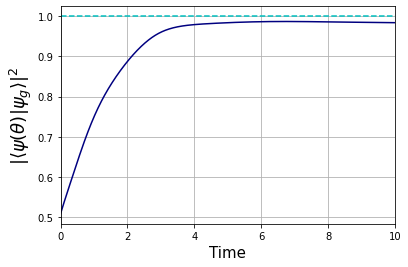

In [28]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

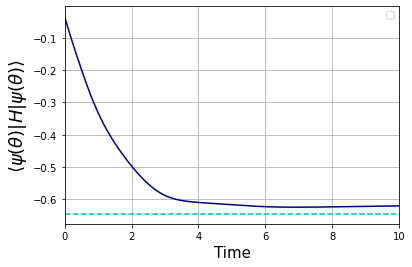

In [29]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

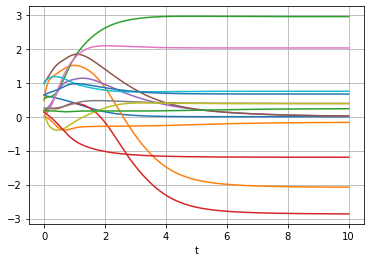

In [27]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [28]:
for i in range(coeff*N):
    print(Y[-1][i])

-0.0009822630236511927
-2.0773526708935393
2.9480469499510007
-2.864729471160893
0.018013947434421584
0.018293766962629833
2.024719767673083
0.39156328242486227
0.38360063620482215
0.7497325366621957
0.6668533985677328
-0.1685353591678328
0.23401062171479337
-1.1941919452995613


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

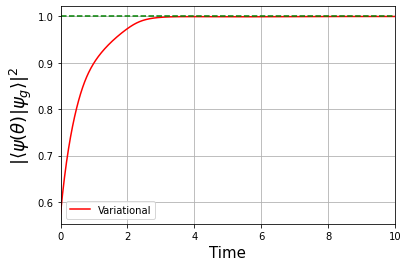

(0.0, 10.0)

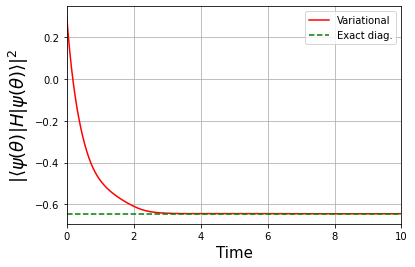

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
